# Poor_Att
Give the record of student's attendance percentage for the semester 
who has less than 33% of detartment average


## Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql
from ipynb.fs.defs.CW_Preprocessing import *
from ipynb.fs.defs.Student_Att import *
from ipynb.fs.defs.Module_Att import *

## Functions 

In [28]:
def mod_attandence_avg_per_week(df_student_attendance,dfsessions):
    '''
    Function calculates average attendance per week for each student
    
    input:
        df_student_attendance, dataframe type 
        dfsessions, dataframe type
    return: 
        total_attendance_percent, float type
        df_course_avg, dataframe type  
    '''
    
    df_percentage=attendence_percent(df_student_attendance)
    dfsessions=dfsessions[['session_id','course','week_no']]
    df_percentage_t = df_percentage.transpose()
    df_percentage_t.index.names = ['session_id']
    df_percentage_t = df_percentage_t.rename(columns={0: 'att_percent'})
    total_attendance_percent=df_percentage_t['att_percent'].mean()
    df_percentage_t1 = pd.merge(df_percentage_t,dfsessions,on='session_id',how='left')
    df_percentage_t1['att_percent']=df_percentage_t1['att_percent'].astype('float')
    df_course_avg=df_percentage_t1.pivot_table(index='course',\
                                                   columns='week_no',\
                                                   values='att_percent',\
                                                   aggfunc='mean')
    df_course_avg['total%'] = df_course_avg.mean(axis=1)
    return total_attendance_percent,df_course_avg.round(3)

In [29]:
def highlight_greater(val,avg):
    '''
    Setting background Colors 
    of table cells 
    value is a cell value. 
    '''
    
    if val > avg:
        return 'background-color: green'
    else:
        return ''

def change_bcolor(dfData,total_attendance_percent):
    """
    applying formatting function to the dataframe.
    """
    
    styledOutput=dfData.style.apply(highlight_greater,avg=total_attendance_percent).format()
    return styledOutput

In [30]:
def std_attendence_avg_per_week(df_student_attendance,dfsessions):
    '''
    Function calculates average percentage of attendance per week for all students 
    
    input:
        df_student_attendance, dataframe type 
        dfsessions, dataframe type
    return: 
        df_course_avg, dataframe type  
    '''
    
    # Creating a new dataframe by merging COA111 and COA122
    df = df_stu_with_sessions(df_student_attendance,dfsessions)
    df_new=df.iloc[:, 7:]
    
    # Creating a new dataframe to store the results
    results_df = pd.DataFrame()

    for col in df_new.columns[1:]:
        student_attendance = df_new[[col]]
        student_attendance = student_attendance.rename(columns={col: 'attendance'})
        student_attendance['week_no'] = df_new['week_no'].astype('int')
        student_attendance1 = student_attendance.groupby(['week_no']).size().reset_index(name='total_classes')
        student_attendance2 = student_attendance.groupby(['week_no']).sum().reset_index()
        student_attendance = pd.merge(student_attendance1, student_attendance2, on=['week_no'])
        student_attendance['attendance_percentage'] = (student_attendance['attendance'] \
                                                       / student_attendance['total_classes'] * 100)
        student_attendance['student_id'] = col
        student_attendance = student_attendance.reset_index(drop=True)
        results_df = pd.concat([results_df, student_attendance], axis=0)


    # Pivot the table to get the required format
    results_df = results_df.pivot(index='student_id', \
                                  columns='week_no',\
                                  values='attendance_percentage')

    # Calculate the total average percentage
    results_df['total_average%'] = results_df.mean(axis=1)
    results_df=results_df.round(2)
    
    return results_df


In [31]:
def poor_Att():
    '''
    Function shows poor attendance & graph for students below 33% of dept avg
    '''
    # getting dataframes DB
    df_student_attendance,dfsessions=get_tables()
    
    # Displaying students and module attendance% per week
    total_attendance_percent,df_course_avg = mod_attandence_avg_per_week(df_student_attendance,dfsessions)
    df_std_avg_att = std_attendence_avg_per_week(df_student_attendance,dfsessions)
    df=df_std_avg_att[df_std_avg_att['total_average%']<total_attendance_percent/3]
    df = df.sort_values('total_average%')
    #display(df)
    display(change_bcolor(df,total_attendance_percent))
    display(df_course_avg)
    
    # plotting the for the students and module attendance% per week
    fig, ax = plt.subplots( figsize=(12, 6))
    for i, row in df.iterrows():
        ax.scatter(df.columns[0:6], row[0:6],label=f'SID: {row.name}')   
    for i, row in df_course_avg.iterrows():
        ax.plot(df_course_avg.columns[0:6], row[0:6], label=i)
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Attendance Precetage')
    ax.legend(loc='best')  
    plt.show()
    

## Testing 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

week_no,1,2,3,4,5,6,total%
course,,,,,,,
COA111,67.588,75.126,69.347,69.095,69.347,NaN,70.101
COA122,52.596,46.901,46.566,49.749,42.211,76.382,52.401


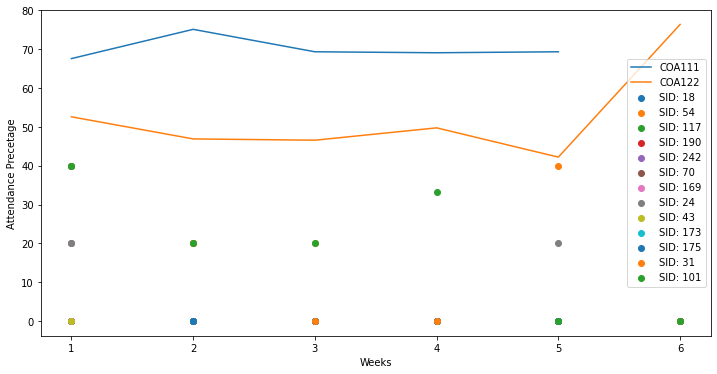

In [32]:
poor_Att()